In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import Yukawa_SINDy as ys
import pysindy as ps
from importlib import reload

In [ ]:
# included to update Yukawa_SINDy.py version used in this notebook as changes are made
reload(ys)

In [3]:
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

In [4]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

# Analysis of Yukawa 2-body data using Weak SINDy

The purpose of this notebook is to use a weak SINDy analysis on 2-body trajectories to see if the sparse recovery of simulation coefficients is improved. Results from the analysis of the same system using only one trajectory with strong-form SINDy (the original formulation) is shown in the notebook 'Yukawa2body.ipynb'.

Here, we will start by using one trajectory of the 2-body equations, as we did before, and then possibly extend to more trajectories.

## `std_dev=0.01`

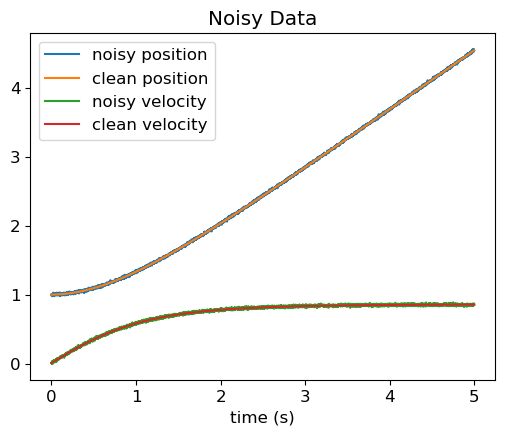

In [43]:
sim = ys.Yukawa_simulation()
sim.simulate(5)
sim.add_gaussian_noise(noise_level=0.01)
sim.plot()

In [ ]:
def generate_libraries(t_for_weak):
    # define lambdas for library functions
    library_functions = [
        # lambda x: 1.0, get rid of this term because it is being duplicated and causing an error
        lambda x: x,
        lambda x: np.exp(-x) / x,
        lambda x: np.exp(-x) / x**2,
        lambda x: np.exp(-x) / x**3,
        lambda x: np.exp(-x) / x**4,
    ]

    # define names for library functions
    library_function_names = [
        # lambda x: 1,
        lambda x: x,
        lambda x: "exp(-" + x + ") / " + x,
        lambda x: "exp(-" + x + ") / " + x + "^2",
        lambda x: "exp(-" + x + ") / " + x + "^3",
        lambda x: "exp(-" + x + ") / " + x + "^4",
    ]

    # generate weak form library
    np.random.seed(120398)
    # Note: WSINDy uses a random selection of integration subdomains, so
    # we fix a seed number so we use the same set of subdomains each time
    # this function is called. 
    weak_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        spatiotemporal_grid=t_for_weak,
        function_names=library_function_names)

    # generate strong form library
    strong_lib = ps.CustomLibrary(
        library_functions=library_functions, 
        function_names=library_function_names)
    
    return weak_lib, strong_lib

In [260]:
def scan_thresholds(x_train, t_train, weak_lib, strong_lib, thresholds, verbose=False):
    precision = 5
    num_simeq = 3
    complexities = np.empty((2,0))
    fit_weak = True
    fit_strong = True
    for thresh in thresholds:
        # set optimizer
        opt = ps.STLSQ(threshold=thresh)
        if verbose:
            print("STLSQ threshold:", thresh)
        # fit weak model
        if fit_weak:
            weak_model = ps.SINDy(feature_names=["x", "v"],
                                feature_library=weak_lib, optimizer=opt)
            weak_model.fit(x_train)
            if verbose:
                print("\nWeak model")
                weak_model.print(precision=precision)
            weak_complexity = weak_model.complexity
        else:
            weak_complexity = -1

        # fit strong model
        if fit_strong:
            strong_model = ps.SINDy(feature_names=["x", "v"],
                                    feature_library=strong_lib, optimizer=opt)
            strong_model.fit(x_train, t=t_train)
            if verbose:
                print("\nStrong model")
                strong_model.print(precision=precision)
                print("\n" + 100*"=" + "\n")
            strong_complexity = strong_model.complexity
        else:
            strong_complexity = -1

        # stop fitting models if complexity is below num_simeq
        if weak_complexity <= num_simeq:
            fit_weak = False
        if strong_complexity <= num_simeq:
            fit_strong = False

        # append new complexities to list
        new_complexities = np.array([weak_complexity, strong_complexity]).reshape((2,1))
        complexities = np.append(complexities, new_complexities, axis=1)
        
    return complexities


In [261]:
thresholds = np.arange(0, 0.2, 0.01)
libs = generate_libraries(sim.t)
complexities = scan_thresholds(sim.x, sim.t, *libs, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = 0.01985 x + 0.52106 v + 10.03095 exp(-x) / x + 0.81931 exp(-v) / v + -43.87139 exp(-x) / x^2 + -0.17714 exp(-v) / v^2 + 60.47987 exp(-x) / x^3 + 0.01420 exp(-v) / v^3 + -29.77577 exp(-x) / x^4 + -0.00030 exp(-v) / v^4
(v)' = -0.01941 x + 0.32743 v + -5.68626 exp(-x) / x + -0.52302 exp(-v) / v + 28.41971 exp(-x) / x^2 + 0.12610 exp(-v) / v^2 + -36.01176 exp(-x) / x^3 + -0.01096 exp(-v) / v^3 + 17.00918 exp(-x) / x^4 + 0.00024 exp(-v) / v^4

Strong model
(x)' = 0.26790 x + -0.39245 v + 69.10195 exp(-x) / x + -0.02851 exp(-v) / v + -214.72287 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + 231.54884 exp(-x) / x^3 + -85.56737 exp(-x) / x^4
(v)' = 0.19802 x + -1.09564 v + 75.12495 exp(-x) / x + -0.00774 exp(-v) / v + -253.10291 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + 301.64100 exp(-x) / x^3 + -121.92061 exp(-x) / x^4


STLSQ threshold: 0.01

Weak model
(x)' = -0.00471 x + 1.03497 v + -0.13317 exp(-x) / x + -0.03144 exp(-v) / v + 0.00343 exp(-v) / v^2 + 0.4150

With this realization of subsets of the integration subdomains, WSINDy discovers the approximately correct model with a threshold of 0.05. 

In [262]:
def plot_complexities(thresholds, complexities):
    fig, ax = plt.subplots(1,1)
    labels = ["Weak model", "Strong model"]
    for i in range (2):
        ax.plot(thresholds, complexities[i], 'o', label=labels[i])
    ax.hlines(3, min(thresholds), max(thresholds),linestyles='dashed', lw=1.5, label="Simulation Equations")
    ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(MultipleLocator(base=2))
    ax.legend()
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Number of terms")
    ax.set_title("Noise level: " + str(np.round(sim.noise_level, 2)))
    fig.tight_layout()
    return fig, ax

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

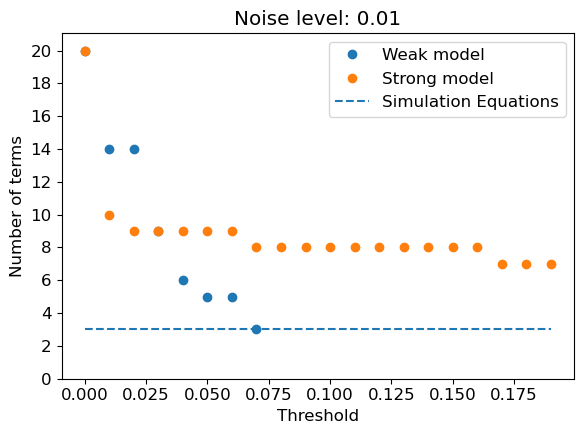

In [263]:
plt.rcParams["figure.figsize"] = (6,4.5)
plt.rcParams["font.size"] = 12
plot_complexities(thresholds, complexities)

A more complete scan,

STLSQ threshold: 0.0

Weak model
(x)' = 0.01985 x + 0.52106 v + 10.03095 exp(-x) / x + 0.81931 exp(-v) / v + -43.87139 exp(-x) / x^2 + -0.17714 exp(-v) / v^2 + 60.47987 exp(-x) / x^3 + 0.01420 exp(-v) / v^3 + -29.77577 exp(-x) / x^4 + -0.00030 exp(-v) / v^4
(v)' = -0.01941 x + 0.32743 v + -5.68626 exp(-x) / x + -0.52302 exp(-v) / v + 28.41971 exp(-x) / x^2 + 0.12610 exp(-v) / v^2 + -36.01176 exp(-x) / x^3 + -0.01096 exp(-v) / v^3 + 17.00918 exp(-x) / x^4 + 0.00024 exp(-v) / v^4

Strong model
(x)' = 0.26790 x + -0.39245 v + 69.10195 exp(-x) / x + -0.02851 exp(-v) / v + -214.72287 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + 231.54884 exp(-x) / x^3 + -85.56737 exp(-x) / x^4
(v)' = 0.19802 x + -1.09564 v + 75.12495 exp(-x) / x + -0.00774 exp(-v) / v + -253.10291 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + 301.64100 exp(-x) / x^3 + -121.92061 exp(-x) / x^4


STLSQ threshold: 0.05

Weak model
(x)' = -0.00075 x + 1.00042 v
(v)' = 1.00714 exp(-x) / x + 0.00095 exp(-v) / v + 0.97867 exp(-x) / x^2

Stro

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

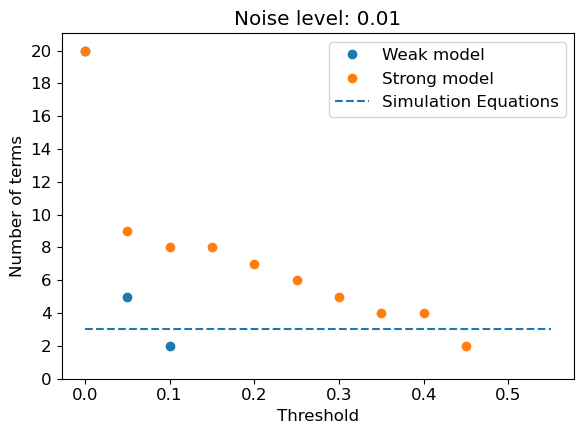

In [ ]:
thresholds = np.arange(0, 0.6, 0.02)
libs = generate_libraries(sim.t)
complexities = scan_thresholds(sim.x, sim.t, *libs, thresholds, verbose=True)
plot_complexities(thresholds, complexities)

From this, we can see that strong form discovers only the correct leading terms, but never actually discovers the correct terms, a result that we also found before.

In [ ]:
# code to be used for spot checking whatever threshold
threshold = 0.07
opt = ps.STLSQ(threshold=threshold)
weak_lib, strong_lib = generate_libraries(sim.t)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(sim.x)
weak_model.print(precision=5)

(x)' = 0.99776 v
(v)' = 1.79076 exp(-x) / x + 0.00921 exp(-v) / v


### Multiple trajectories

We can also generate many trajectories with different initial conditions and use that to train SINDy. This is what we were already doing for the three-body case, but we can see how much it improves the performance of SINDy here.

Note that we generate random initial conditions in the following way:

- *Initial positions*: taken from a normal distribution centered at 1 with std. dev. of 0.2
- *Initial velocities*: taken from a normal distribution centered at 0.01 with a std. dev. of 0.002, also with a random +/- sign.

This was done carefully so as to avoid there being zeros in the initial conditions, which create problems for the solver and for SINDy because of the presence of the rational terms.

In [365]:
def generate_training_data(n_sims=200, duration=5, dt=0.001, noise_level=0.01):
    # generates list of multiple trajectories with random initial conditions
    # generate init cond
    rng = np.random.default_rng(seed=4862039)
    x0s = rng.normal(1, 0.2, n_sims)
    v0s = rng.choice([-1,1], n_sims) * rng.normal(-0.01, 0.002, n_sims)
    # simulate
    sims = []
    for i in range(n_sims):
        sim = ys.Yukawa_simulation()
        sim.simulate(duration, dt=dt, x0=x0s[i], v0=v0s[i])
        sim.add_gaussian_noise(noise_level=noise_level)
        sims.append(sim)
    
    return sims

In [344]:
sims = generate_training_data(noise_level=0.1)

In [345]:
x_train = [sim.x for sim in sims] # if sim.x.shape[0] == 5000]
t_train = sims[0].t

In [346]:
weak_lib, strong_lib = generate_libraries(t_train)

In [358]:
opt = ps.STLSQ(threshold=0.5)
strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
strong_model.fit(x_train, t=t_train, multiple_trajectories=True)
strong_model.print(precision=5)

(x)' = 25.02832 exp(-x) / x + -46.32102 exp(-x) / x^2 + 26.70239 exp(-x) / x^3 + -4.86520 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x) / x^2 + 3.09421 exp(-x) / x^3 + -0.98733 exp(-x) / x^4


In [348]:
opt = ps.STLSQ(threshold=0.2)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)

(x)' = 0.97920 v
(v)' = 1.02562 exp(-x) / x + 0.86036 exp(-x) / x^2


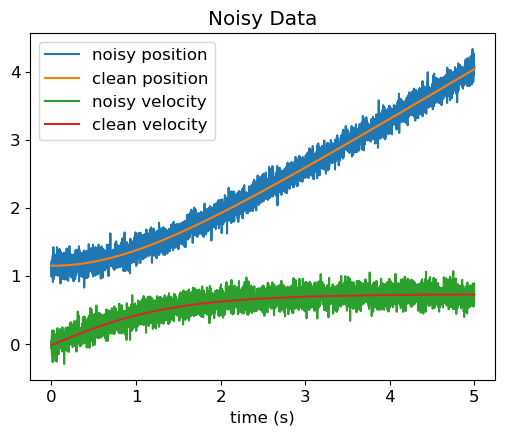

In [364]:
sims[38].plot()

## `std_dev=0.10`